# Captum does support regression
try shap.DeepExplainer?

In [1]:
from stable_baselines3 import PPO, SAC

import pandas as pd
#import numpy as np

from captum.attr import ShapleyValueSampling, FeaturePermutation
import torch
#import plotly.figure_factory as ff
#import plotly.express as px

import KBMproject.utilities as utils

%matplotlib inline

In [2]:
DISCRETE_NAME = '20 bin PPO 500 results\default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500.zip'
CONT_NAME = 'Models\Victim\SAC_citylearn_challenge_2022_phase_2_Building_6_default_rwd_MARLISA_hyperparams_500.zip'
SAMPLES = 10_000

In [3]:
discrete_agent = PPO.load(path=f"{DISCRETE_NAME}")
cont_agent =  SAC.load(path=f"{CONT_NAME}")

In [4]:
discrete_svs = ShapleyValueSampling(utils.extract_actor(discrete_agent))
cont_svs = ShapleyValueSampling(utils.extract_SACtor(cont_agent))

In [5]:
discrete_fp = FeaturePermutation(utils.extract_actor(discrete_agent))
cont_fp = FeaturePermutation(utils.extract_SACtor(cont_agent))

In [6]:
df_discrete = pd.read_csv(r'20 bin PPO 500 results\rebaseline obs.csv',)
df_discrete['actions'] = pd.read_csv(r'20 bin PPO 500 results\rebaseline a.csv',)

In [7]:
df_cont = pd.read_csv(r'default SAC 500 norm space results\baseline_obs-a.csv',
                       index_col=0,
                       #header=0,
                       dtype='float32')

In [8]:
discrete_shap = discrete_svs.attribute(torch.from_numpy(df_discrete.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_discrete['actions'].to_numpy().astype('int64')).to('cuda'),
                             n_samples=SAMPLES,
                             show_progress=True,
                             ).detach().cpu().numpy()

Shapley Value Sampling attribution:   0%|          | 0/310001 [00:00<?, ?it/s]

In [19]:
cont_shap = discrete_svs.attribute(torch.from_numpy(df_cont.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_cont['actions'].to_numpy()).to('cuda'),
                             n_samples=SAMPLES,
                             show_progress=True,
                             ).detach().cpu().numpy()

Shapley Value Sampling attribution:   0%|          | 0/310001 [00:00<?, ?it/s]

RuntimeError: gather(): Expected dtype int64 for index

In [ ]:
df_mean_shap = pd.DataFrame([discrete_shap.mean(axis=0),cont_shap.mean(axis=0)],
                            index=['Discrete_PPO','SAC'],
                            columns=df_cont.columns[:-1])

<Axes: title={'center': 'Mean Shapley Value Sampling Feature Importance Over One Episode'}, xlabel='Features', ylabel='Mean Absolute Shapley Value Sample'>

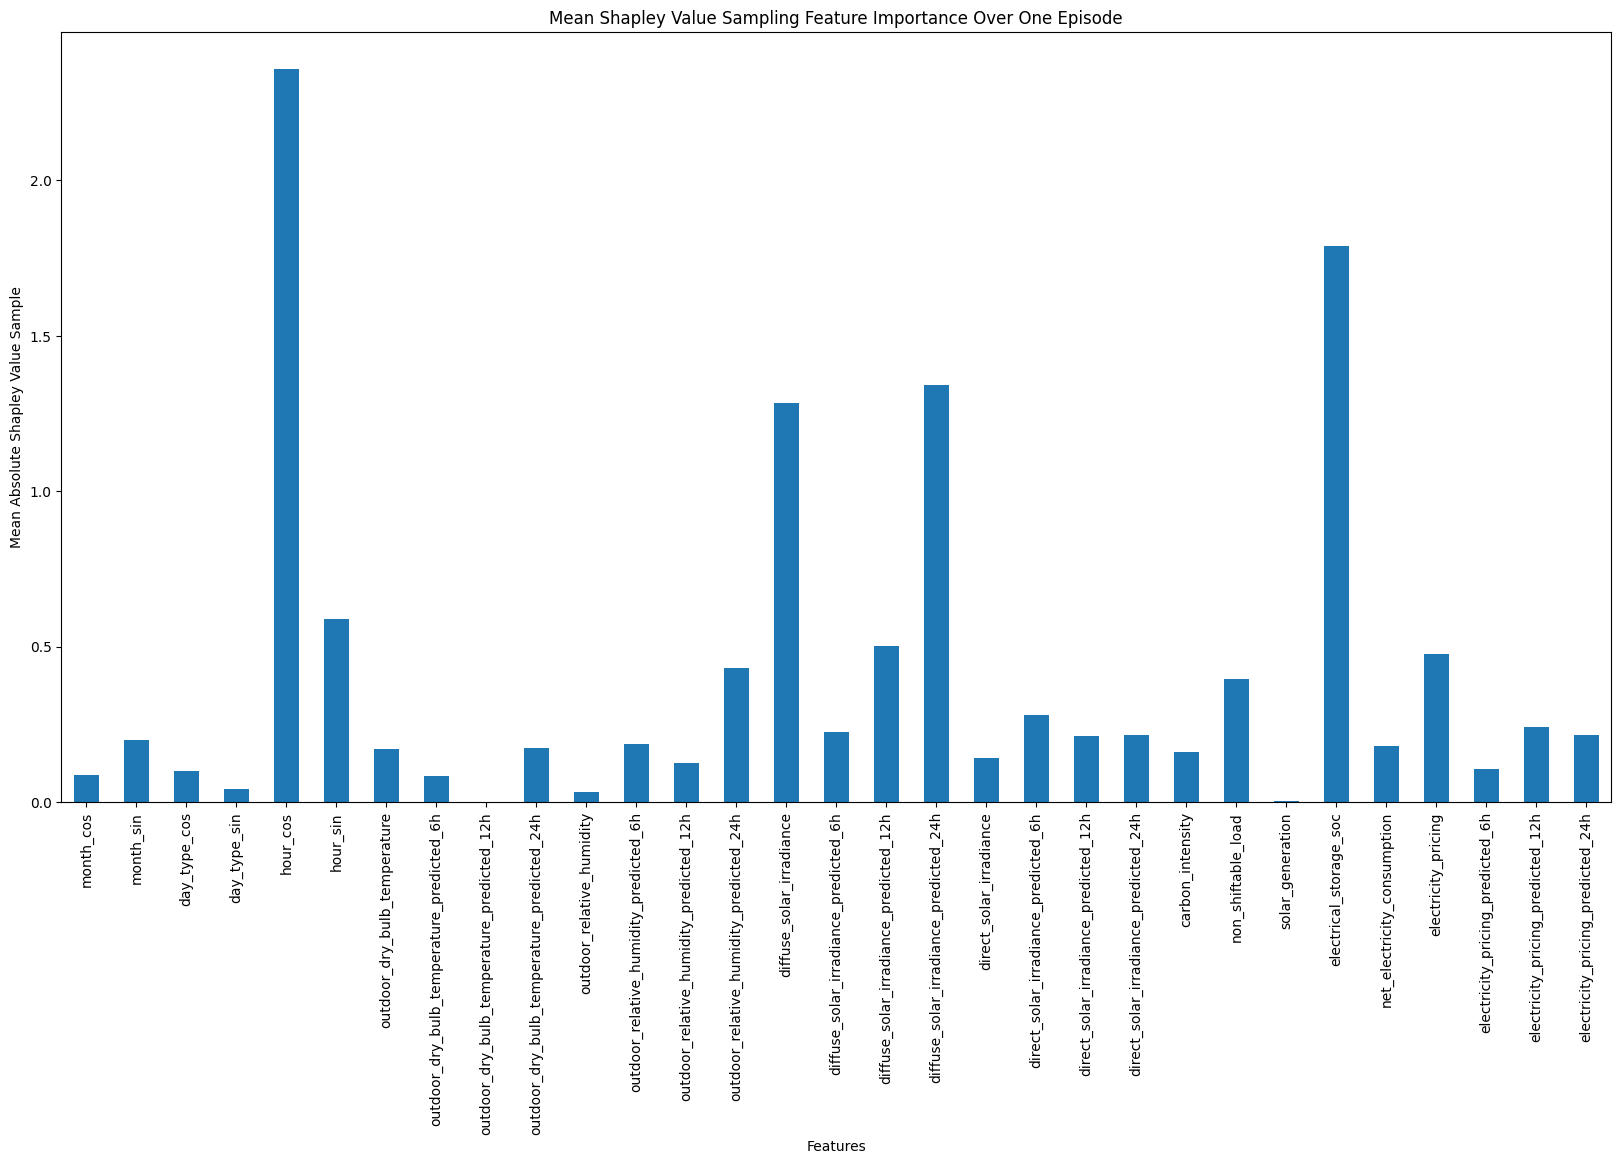

In [ ]:
df_mean_shap.T['Discrete_PPO'].abs().plot.bar(
    xlabel='Features',
    ylabel='Mean Absolute Shapley Value Sample',
    title='Mean Shapley Value Sampling Feature Importance Over One Episode',
    figsize=(20,10),
)

<Axes: title={'center': 'Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode'}, xlabel='Features', ylabel='Mean Absolute Shapley Value Sample'>

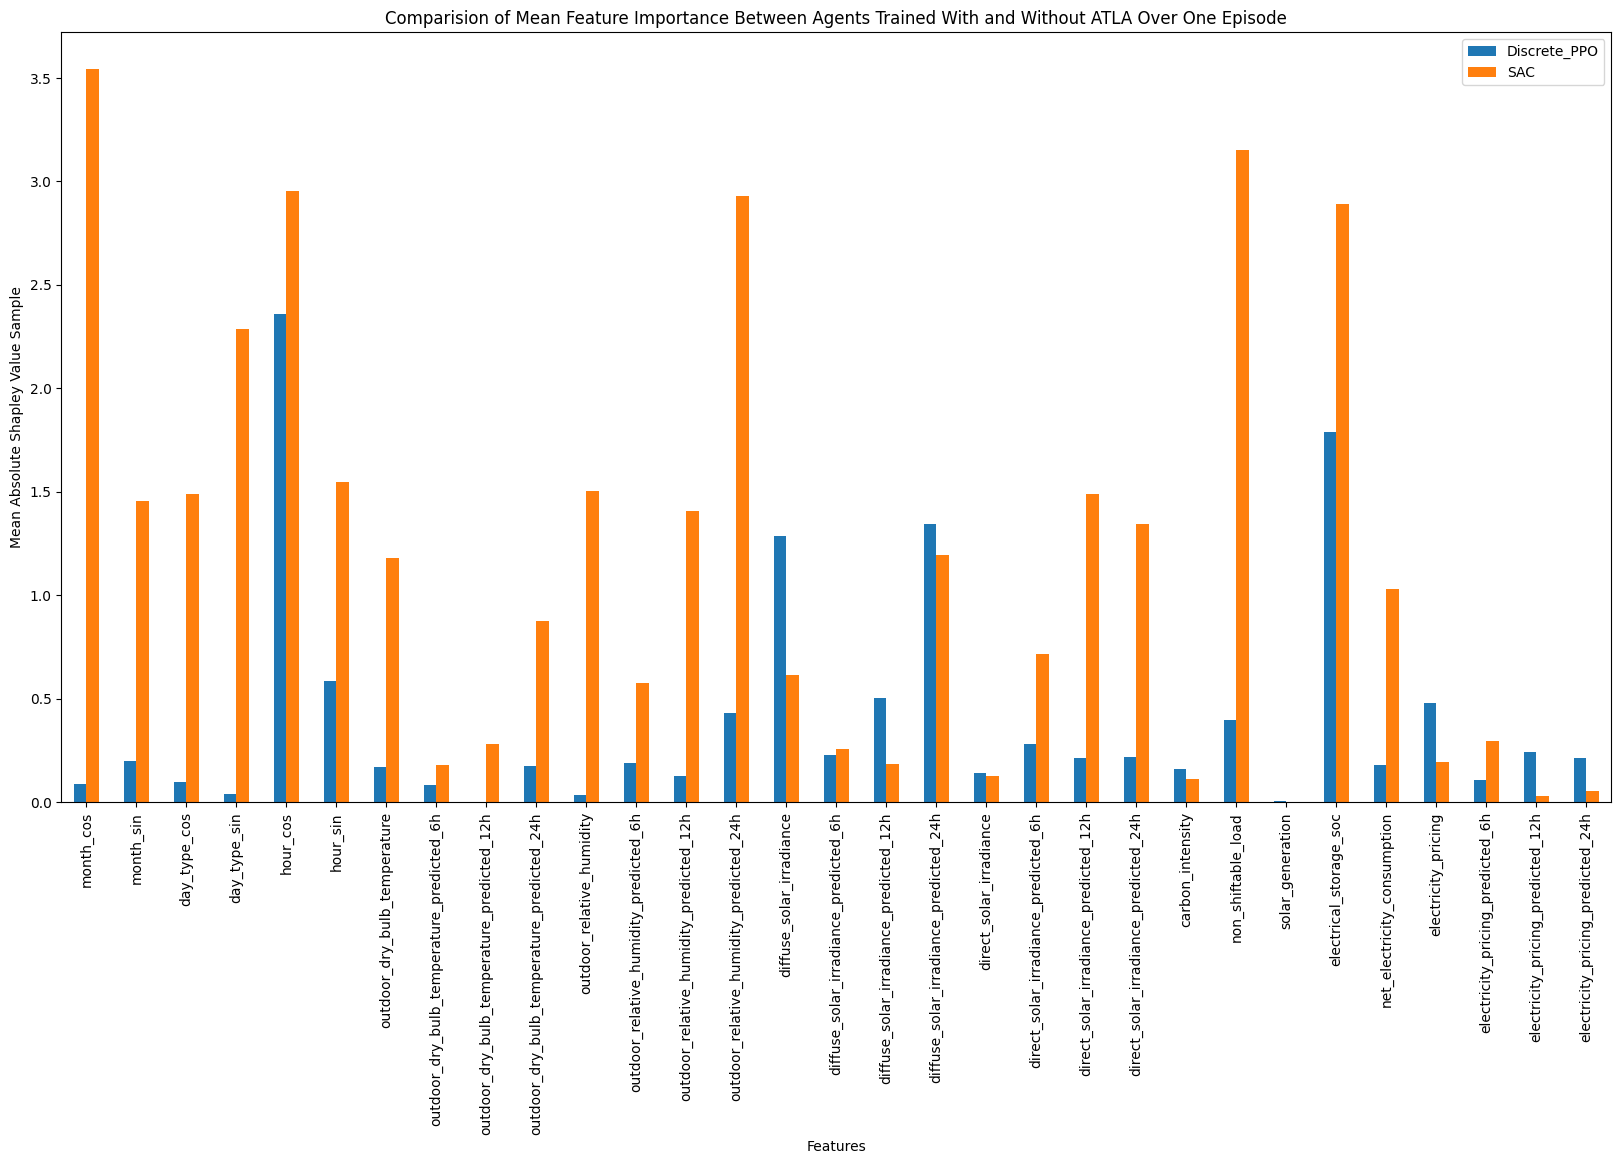

In [ ]:
df_mean_shap.T.abs().plot.bar(
    xlabel='Features',
    ylabel='Mean Absolute Shapley Value Sample',
    title='Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode',
    figsize=(20,10),
)

<Axes: title={'center': 'Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode'}, xlabel='Features', ylabel='Mean Absolute Shapley Value Sample'>

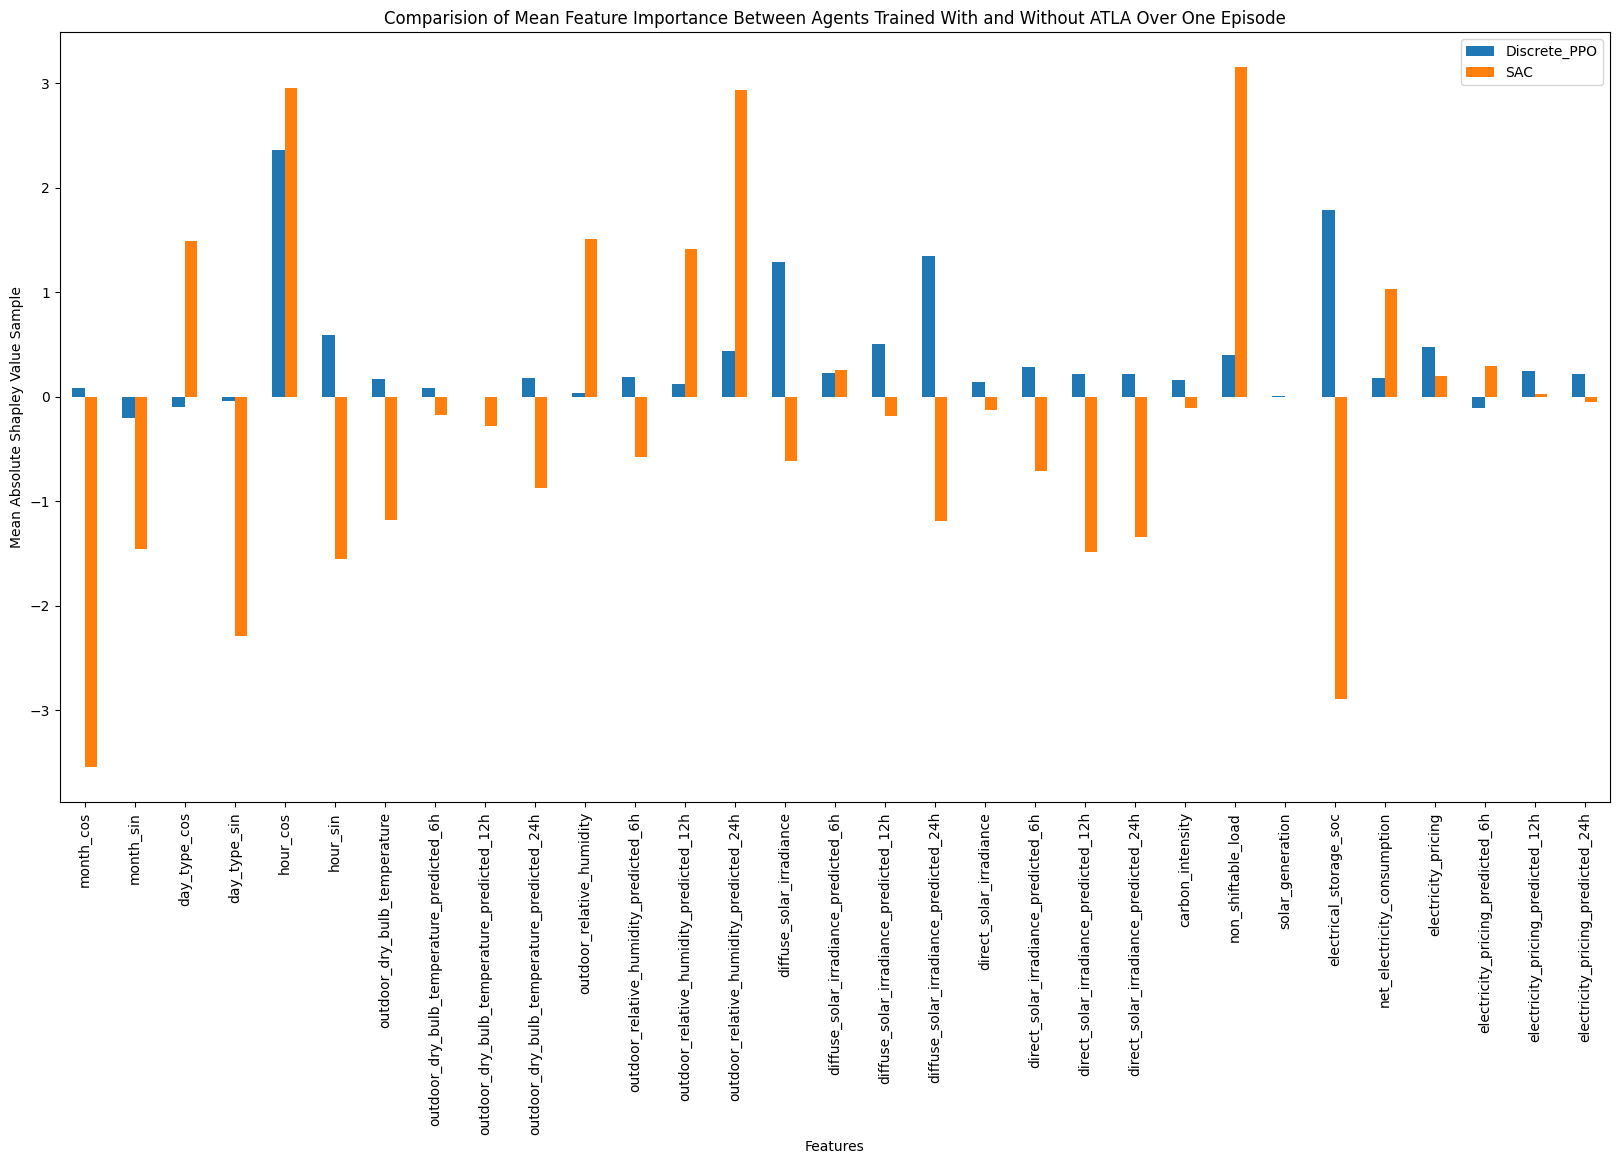

In [ ]:
df_mean_shap.T.plot.bar(
    xlabel='Features',
    ylabel='Mean Absolute Shapley Value Sample',
    title='Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode',
    figsize=(20,10),
)

Compared to the conventionally trained agent, the ATLA agent relies more on temporal features (which were not perturbed), while use other less. It also relies more on:
- non-shiftable loads 
- electricity consumption
- electricity price
while ignoring:
- the SoC (intuitively seems important, and second most important feature for the other agent)
- direct solar irradiance (though this wasn't an import feature for the other)
- 12h humidity forecast

TODO: explain where the numbers come from for SVS:

- The number are like forces, increasing or decreasing the prediction from the mean. So large absolute values indicate a feature's importance. 

Should I train an ATLA agent where all features are equally perturbed?

How do these relate to the sizes of mean_diff, are the correlated with the perturbation size? Doesn't look like it

Heatmap like the observation visualizations?

In [ ]:
agent_fp_importances = discrete_fp.attribute(torch.from_numpy(df_discrete.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_discrete['actions'].to_numpy().astype('int64')).to('cuda'),
                             show_progress=True,
                             ).detach().cpu().numpy()

Feature Permutation attribution:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
atla_fp_importances = discrete_fp.attribute(torch.from_numpy(df_cont.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_cont['actions'].to_numpy()).to('cuda'),
                             show_progress=True,
                             ).detach().cpu().numpy()

Feature Permutation attribution:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
df_mean_fp = pd.DataFrame([agent_fp_importances.mean(axis=0),atla_fp_importances.mean(axis=0)],
                            index=['Discrete_PPO','SAC'],
                            columns=df_cont.columns[:-1])

<Axes: title={'center': 'Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode'}, xlabel='Features', ylabel='Mean Feature Permutation Importance'>

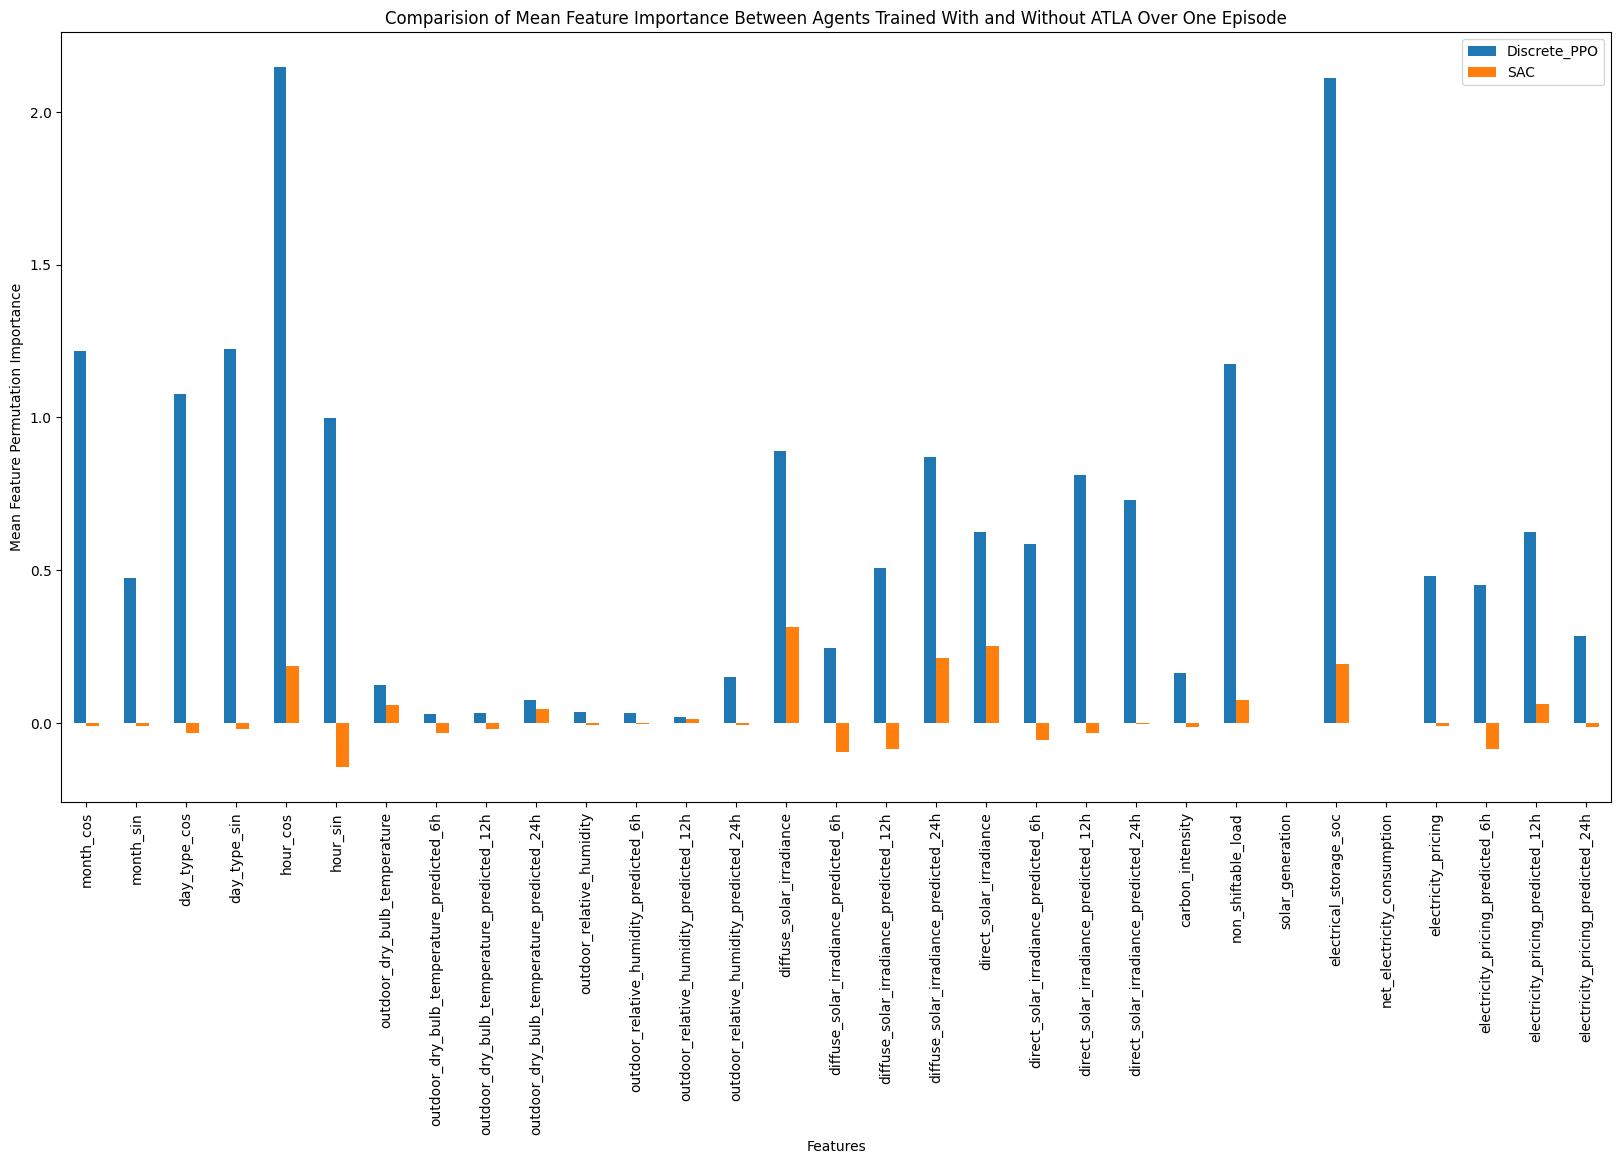

In [ ]:
df_mean_fp.T.plot.bar(
    xlabel='Features',
    ylabel='Mean Feature Permutation Importance',
    title='Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode',
    figsize=(20,10),
)

- Negative values indicate that shuffling features is improving model accuracy, because this is a small chance effect, it suggests these features are not important.
- overall we see the ATLA model is less sensitive to feature permutations, which makes sense given that it was trained on them
